# Notebook Purpose 

Is a pairs trading strategy for ADA/SOL based on dynamic hedging ratio a **profitable trading strategy?**

In [1]:
%load_ext autoreload
%autoreload 2

import lakeapi 
import datetime as dt
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly
import plotly.graph_objects as go 
import numpy as np
from itertools import combinations

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import nolds
pd.set_option('display.max_rows', 100)
from helpers import calculate_rolling_ols_spread_fast
import itertools 

from pricing_signals import PricingSignal
from trading_strategy import BollingerBandTradeStrategy
from portfolio_manager.portfolio_manager import PortfolioManager
from portfolio_manager.baseline_trading_strategy import BuyHoldStrategy
from data_processing import summary_streaks_seconds

/Users/vivbear/Documents/Quant_Research/Projects/venv/lib/python3.13/site-packages/nolds/datasets.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [8]:
resampled_df = pd.read_parquet('data/level1crypto_raw_origin_times_resampled.parquet')
TRAINING_START = dt.datetime(2025, 4, 1)
TRAINING_END = dt.datetime(2025, 7, 1)
train_df, test_df = resampled_df[(resampled_df.index>=TRAINING_START) & ((resampled_df.index)<=TRAINING_END)], resampled_df[resampled_df.index >=TRAINING_END]

# Question: Is an hourly updating OLS pairs trading strategy for ADA/SOL MORE or LESS profitable than an appropriate baseline benchmark strategy? 

- Need to take into account that there is another risk of overfitting/risk since we OPTIMISED and CHOSE the hourly lookback window BOTH on the training data
  - Note - deprecated - since original training data had too much missing data - perhaps not the most reliable 

In [9]:
pairs_training_df = train_df[train_df['symbol'].isin(['ADA-USDT', 'SOL-USDT', 'BTC-USDT'])].pivot(
    columns='symbol', 
    values=['bid_0_price', 'ask_0_price', 'bid_0_size', 'ask_0_size', 'mid_price']
).rename(columns={
    'bid_0_price': 'bid_price', 
    'ask_0_price': 'ask_price', 
    'bid_0_size': 'bid_size', 
    'ask_0_size': 'ask_size'
}).swaplevel(axis=1)

#CLEAN OUT due to missing data concerns

In [10]:
SECONDS_PER_MINUTE = 60
pairs_training_df.swaplevel(axis=1)['mid_price'].apply(summary_streaks_seconds)/SECONDS_PER_MINUTE

symbol,BTC-USDT,SOL-USDT,ADA-USDT
count,0.0,2.000000,4.833333
mean,NaN,0.722222,0.396552
std,NaN,1.872628,1.206311
min,NaN,0.166667,0.166667
25%,NaN,0.166667,0.166667
50%,NaN,0.166667,0.166667
75%,NaN,0.166667,0.166667
90%,NaN,0.316667,0.166667
95%,NaN,3.183333,0.266667
99%,NaN,5.970000,4.893333


In [5]:
#most likely - safe to front-fill 

In [11]:
pairs_training_df.isna().sum()

symbol             
BTC-USDT  bid_price     0
SOL-USDT  bid_price    52
ADA-USDT  bid_price    69
BTC-USDT  ask_price     0
SOL-USDT  ask_price    52
ADA-USDT  ask_price    69
BTC-USDT  bid_size      0
SOL-USDT  bid_size     52
ADA-USDT  bid_size     69
BTC-USDT  ask_size      0
SOL-USDT  ask_size     52
ADA-USDT  ask_size     69
BTC-USDT  mid_price     0
SOL-USDT  mid_price    52
ADA-USDT  mid_price    69
dtype: int64

In [12]:
cleaned_pairs_training_df = pairs_training_df.ffill()

In [14]:
cleaned_pairs_training_df.isna().sum()

symbol             
BTC-USDT  bid_price    0
SOL-USDT  bid_price    0
ADA-USDT  bid_price    0
BTC-USDT  ask_price    0
SOL-USDT  ask_price    0
ADA-USDT  ask_price    0
BTC-USDT  bid_size     0
SOL-USDT  bid_size     0
ADA-USDT  bid_size     0
BTC-USDT  ask_size     0
SOL-USDT  ask_size     0
ADA-USDT  ask_size     0
BTC-USDT  mid_price    0
SOL-USDT  mid_price    0
ADA-USDT  mid_price    0
dtype: int64

In [15]:
#Variables 
DAYS_IN_WEEK = 7 
HOURS_IN_DAYS = 24
MINUTES_PER_HOUR = 60 
TICKS_PER_MINUTE = 6

BETA_LOOKBACK_BY_FREQUENCY = {
    'hour': 1*MINUTES_PER_HOUR*TICKS_PER_MINUTE,
    'day': 1*HOURS_IN_DAYS*MINUTES_PER_HOUR*TICKS_PER_MINUTE, # 1 day, 
    'week': 7*HOURS_IN_DAYS*MINUTES_PER_HOUR*TICKS_PER_MINUTE,  # 7 days, 
    'month': 30*HOURS_IN_DAYS*MINUTES_PER_HOUR*TICKS_PER_MINUTE, #30 days (1 month)
}

MA_UNITS_BY_FREQUENCY = {
    'hour': 30*MINUTES_PER_HOUR*TICKS_PER_MINUTE, #30 moving average 
    'day': 12*HOURS_IN_DAYS*MINUTES_PER_HOUR*TICKS_PER_MINUTE
}

TRADING_PERIODS_PER_YEAR = TICKS_PER_MINUTE*MINUTES_PER_HOUR*HOURS_IN_DAYS*365

# In-sample training 

Try to find the best possible VERSION of this trading strategy as you can. 

In [23]:
#Part 1: Find the optimal trading strategy parameters based on hourly signal data 

#Note there is no need to use k-fold cross-validation since the entry, exit and MA lookback are really PARAMETERs of the model and so they shoul be trained on the dataset 
entry_threshold = [0.5, 1, 2]
exit_threshold = [0.25, 0.5, 1]
lookback_multiple = [0.25, 0.5, 1, 2]
grid_search = list(itertools.product(entry_threshold, exit_threshold, lookback_multiple))
hedge_lookback = BETA_LOOKBACK_BY_FREQUENCY['hour']

results_by_param = {}
temp_df = cleaned_pairs_training_df

for (entry, exit, lookback_multiple) in grid_search:
    if exit >= entry: 
        continue 
    #Generate signal on rolling OLS with hourly frequency, but with a different SPREAD lookback 
    signal = PricingSignal(hedge_lookback = BETA_LOOKBACK_BY_FREQUENCY['hour'], spread_lookback = int(MA_UNITS_BY_FREQUENCY['hour']*lookback_multiple))
    #use midprices to generate signal 
    signal_results = signal._generate(y = temp_df['ADA-USDT']['mid_price'], x = temp_df['SOL-USDT']['mid_price'])
    #initialise an entry 
    results_by_param[(entry, exit, lookback_multiple)] = {'signal': signal_results}
    #desired positions 
    bb = BollingerBandTradeStrategy(entry_threshold=entry, exit_threshold = exit)
    desired_positions = bb.get_positions(z_score = signal_results['z_score'], beta = signal_results['beta'])
    results_by_param[(entry, exit, lookback_multiple)]['desired_positions'] = desired_positions 
    #portfolio manager 
    pm = PortfolioManager(idealised = True, initial_capital = 10_000, trading_periods_per_year = TRADING_PERIODS_PER_YEAR)
    backtest_results = pm.backtest(close_positions = desired_positions, prices_y = temp_df['ADA-USDT'][['bid_price', 'ask_price']], prices_x = temp_df['SOL-USDT'][['bid_price', 'ask_price']])
    results_by_param[(entry, exit, lookback_multiple)]['backtest'] = backtest_results

100%|██████████| 786241/786241 [01:10<00:00, 11220.18it/s]


In [17]:
results_by_param.keys()

dict_keys([(0.5, 0.25, 0.25), (0.5, 0.25, 0.5), (0.5, 0.25, 1), (0.5, 0.25, 2), (1, 0.25, 0.25), (1, 0.25, 0.5), (1, 0.25, 1), (1, 0.25, 2), (1, 0.5, 0.25), (1, 0.5, 0.5), (1, 0.5, 1), (1, 0.5, 2), (2, 0.25, 0.25), (2, 0.25, 0.5), (2, 0.25, 1), (2, 0.25, 2), (2, 0.5, 0.25), (2, 0.5, 0.5), (2, 0.5, 1), (2, 0.5, 2), (2, 1, 0.25), (2, 1, 0.5), (2, 1, 1), (2, 1, 2)])

In [18]:
sharpe_ratios = {k: results_by_param[k]['backtest']['sharpe'] for k in results_by_param.keys()}
max(sharpe_ratios, key = sharpe_ratios.get)
sharpe_ratios

(2, 0.5, 1)

{(0.5, 0.25, 0.25): np.float64(-13.731961870047687),
 (0.5, 0.25, 0.5): np.float64(-13.557239102762235),
 (0.5, 0.25, 1): np.float64(-11.516632059690988),
 (0.5, 0.25, 2): np.float64(-11.177079835737244),
 (1, 0.25, 0.25): np.float64(-1.5634371268177822),
 (1, 0.25, 0.5): np.float64(-2.1920582730812055),
 (1, 0.25, 1): np.float64(-3.704469317257589),
 (1, 0.25, 2): np.float64(-2.775143355952588),
 (1, 0.5, 0.25): np.float64(-3.9372529089409114),
 (1, 0.5, 0.5): np.float64(-4.7267575232683425),
 (1, 0.5, 1): np.float64(-5.1596721174514935),
 (1, 0.5, 2): np.float64(-5.127044082223099),
 (2, 0.25, 0.25): np.float64(3.821793663686138),
 (2, 0.25, 0.5): np.float64(2.10916522791371),
 (2, 0.25, 1): np.float64(2.7500713696964763),
 (2, 0.25, 2): np.float64(2.2869633277407506),
 (2, 0.5, 0.25): np.float64(3.2468036099562108),
 (2, 0.5, 0.5): np.float64(3.8816987249222326),
 (2, 0.5, 1): np.float64(3.9963564710158197),
 (2, 0.5, 2): np.float64(2.0553857604161965),
 (2, 1, 0.25): np.float64(1.9

In [20]:
winner = results_by_param[(2, 0.5, 1)]
winner['backtest']['sharpe']

np.float64(3.9963564710158197)

<Axes: xlabel='origin_time'>

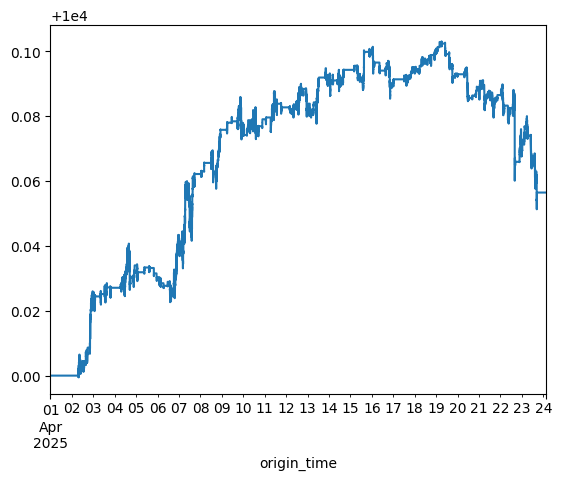

In [21]:
winner['backtest']['equity_curve'].plot()

In [ ]:
#Comparison to baseline strategy - "skill-less strategy"

In [25]:
#Long unit each of ADA/SOL 

#Part 1: Find the optimal trading strategy parameters based on hourly signal data 
temp_df = cleaned_pairs_training_df

desired_positions = pd.DataFrame({'position_y': pd.Series(1.0, index = temp_df.index), 'position_x': pd.Series(1.0, index = temp_df.index)})
#portfolio manager 
pm = PortfolioManager(idealised = True, initial_capital = 10_000, trading_periods_per_year = TRADING_PERIODS_PER_YEAR)
results_buy_hold = pm.backtest(
close_positions = desired_positions, 
prices_y = temp_df['ADA-USDT'][['bid_price', 'ask_price']], 
prices_x = temp_df['SOL-USDT'][['bid_price', 'ask_price']]
)

100%|██████████| 786241/786241 [01:11<00:00, 10982.03it/s]


In [26]:
results_buy_hold['absolute_sharpe']

np.float64(1.0804619470171217)

<Axes: xlabel='origin_time'>

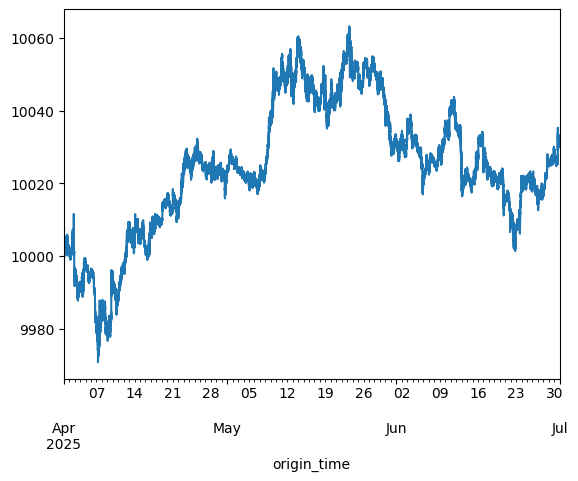

In [28]:
results_buy_hold['equity_curve'].plot()

# Real World Trading Constraints

CRUCIAL 
* Fix the problem of missing data 
* Estimate transaction fees and analyse the effect on the Sharpe ratio 

In [31]:
from portfolio_manager.constants import BINANCE_SPOT_FEE

In [38]:
for col in temp_df.columns.get_level_values(0).unique():
    print(col)

BTC-USDT
SOL-USDT
ADA-USDT


In [32]:
# Estimate spot transaction fees 
entry_threshold = [0.5, 1, 2]
exit_threshold = [0.25, 0.5, 1]
lookback_multiple = [0.25, 0.5, 1, 2]
grid_search = list(itertools.product(entry_threshold, exit_threshold, lookback_multiple))
hedge_lookback = BETA_LOOKBACK_BY_FREQUENCY['hour']

results_by_param = {}
temp_df = cleaned_pairs_training_df

for (entry, exit, lookback_multiple) in grid_search:
    if exit >= entry: 
        continue 
    #Generate signal on rolling OLS with hourly frequency, but with a different SPREAD lookback 
    signal = PricingSignal(hedge_lookback = BETA_LOOKBACK_BY_FREQUENCY['hour'], spread_lookback = int(MA_UNITS_BY_FREQUENCY['hour']*lookback_multiple))
    #use midprices to generate signal 
    signal_results = signal._generate(y = temp_df['ADA-USDT']['mid_price'], x = temp_df['SOL-USDT']['mid_price'])
    #initialise an entry 
    results_by_param[(entry, exit, lookback_multiple)] = {'signal': signal_results}
    #desired positions 
    bb = BollingerBandTradeStrategy(entry_threshold=entry, exit_threshold = exit)
    desired_positions = bb.get_positions(z_score = signal_results['z_score'], beta = signal_results['beta'])
    results_by_param[(entry, exit, lookback_multiple)]['desired_positions'] = desired_positions 
    #portfolio manager 
    pm = PortfolioManager(idealised = True, initial_capital = 10_000, trading_periods_per_year = TRADING_PERIODS_PER_YEAR, transaction_cost= BINANCE_SPOT_FEE)
    backtest_results = pm.backtest(close_positions = desired_positions, prices_y = temp_df['ADA-USDT'][['bid_price', 'ask_price']], prices_x = temp_df['SOL-USDT'][['bid_price', 'ask_price']])
    results_by_param[(entry, exit, lookback_multiple)]['backtest'] = backtest_results

KeyboardInterrupt: 

In [ ]:
# Question - How confident am I that this is overfit? How do I know that what we not fitted on historical noise? 

In [ ]:
# Phase 2 - Add all other major constraints 

#